# 5.4 SAGANの作成

- 本ファイルでは、Self-Attention GANのネットワークを実装と学習をします。


# 5.4 学習目標

1.	SAGANを実装できるようになる


# 事前準備
書籍の指示に従い、本章で使用するデータを用意します

In [1]:
# パッケージのimport
import random
import math
import time
import pandas as pd
import numpy as np
from PIL import Image

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms

In [2]:
# Setup seeds
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)


# Self-Attentionモジュールの実装

In [3]:
class Self_Attention(nn.Module):
    """ Self-AttentionのLayer"""

    def __init__(self, in_dim):
        super(Self_Attention, self).__init__()

        # 1×1の畳み込み層によるpointwise convolutionを用意
        self.query_conv = nn.Conv2d(
            in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.key_conv = nn.Conv2d(
            in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.value_conv = nn.Conv2d(
            in_channels=in_dim, out_channels=in_dim, kernel_size=1)

        # Attention Map作成時の規格化のソフトマックス
        self.softmax = nn.Softmax(dim=-2)

        # 元の入力xとSelf-Attention Mapであるoを足し算するときの係数
        # output = x +gamma*o
        # 最初はgamma=0で、学習させていく
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):

        # 入力変数
        X = x

        # 畳み込みをしてから、サイズを変形する。 B,C',W,H→B,C',N へ
        proj_query = self.query_conv(X).view(
            X.shape[0], -1, X.shape[2]*X.shape[3])  # サイズ：B,C',N
        proj_query = proj_query.permute(0, 2, 1)  # 転置操作
        proj_key = self.key_conv(X).view(
            X.shape[0], -1, X.shape[2]*X.shape[3])  # サイズ：B,C',N

        # かけ算
        S = torch.bmm(proj_query, proj_key)  # bmmはバッチごとの行列かけ算です

        # 規格化
        attention_map_T = self.softmax(S)  # 行i方向の和を1にするソフトマックス関数
        attention_map = attention_map_T.permute(0, 2, 1)  # 転置をとる

        # Self-Attention Mapを計算する
        proj_value = self.value_conv(X).view(
            X.shape[0], -1, X.shape[2]*X.shape[3])  # サイズ：B,C,N
        o = torch.bmm(proj_value, attention_map.permute(
            0, 2, 1))  # Attention Mapは転置してかけ算

        # Self-Attention MapであるoのテンソルサイズをXにそろえて、出力にする
        o = o.view(X.shape[0], X.shape[1], X.shape[2], X.shape[3])
        out = x+self.gamma*o

        return out, attention_map


# Generatorの実装

In [4]:
class Generator(nn.Module):

    def __init__(self, z_dim=20, image_size=64):
        super(Generator, self).__init__()

        self.layer1 = nn.Sequential(
            # Spectral Normalizationを追加
            nn.utils.spectral_norm(nn.ConvTranspose2d(z_dim, image_size * 8,
                                                      kernel_size=4, stride=1)),
            nn.BatchNorm2d(image_size * 8),
            nn.ReLU(inplace=True))

        self.layer2 = nn.Sequential(
            # Spectral Normalizationを追加
            nn.utils.spectral_norm(nn.ConvTranspose2d(image_size * 8, image_size * 4,
                                                      kernel_size=4, stride=2, padding=1)),
            nn.BatchNorm2d(image_size * 4),
            nn.ReLU(inplace=True))

        self.layer3 = nn.Sequential(
            # Spectral Normalizationを追加
            nn.utils.spectral_norm(nn.ConvTranspose2d(image_size * 4, image_size * 2,
                                                      kernel_size=4, stride=2, padding=1)),
            nn.BatchNorm2d(image_size * 2),
            nn.ReLU(inplace=True))

        # Self-Attentin層を追加
        self.self_attntion1 = Self_Attention(in_dim=image_size * 2)

        self.layer4 = nn.Sequential(
            # Spectral Normalizationを追加
            nn.utils.spectral_norm(nn.ConvTranspose2d(image_size * 2, image_size,
                                                      kernel_size=4, stride=2, padding=1)),
            nn.BatchNorm2d(image_size),
            nn.ReLU(inplace=True))

        # Self-Attentin層を追加
        self.self_attntion2 = Self_Attention(in_dim=image_size)

        self.last = nn.Sequential(
            nn.ConvTranspose2d(image_size, 1, kernel_size=4,
                               stride=2, padding=1),
            nn.Tanh())
        # 注意：白黒画像なので出力チャネルは1つだけ

        self.self_attntion2 = Self_Attention(in_dim=64)

    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)
        out = self.layer3(out)
        out, attention_map1 = self.self_attntion1(out)
        out = self.layer4(out)
        out, attention_map2 = self.self_attntion2(out)
        out = self.last(out)

        return out, attention_map1, attention_map2


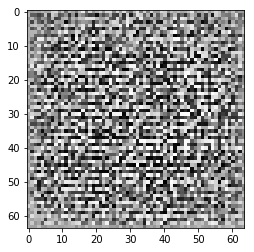

In [5]:
# 動作確認
import matplotlib.pyplot as plt
%matplotlib inline

G = Generator(z_dim=20, image_size=64)

# 入力する乱数
input_z = torch.randn(1, 20)

# テンソルサイズを(1, 20, 1, 1)に変形
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)

# 偽画像を出力
fake_images, attention_map1, attention_map2 = G(input_z)

img_transformed = fake_images[0][0].detach().numpy()
plt.imshow(img_transformed, 'gray')
plt.show()


# Discriminatorの実装

In [6]:
class Discriminator(nn.Module):

    def __init__(self, z_dim=20, image_size=64):
        super(Discriminator, self).__init__()

        self.layer1 = nn.Sequential(
            # Spectral Normalizationを追加
            nn.utils.spectral_norm(nn.Conv2d(1, image_size, kernel_size=4,
                                             stride=2, padding=1)),
            nn.LeakyReLU(0.1, inplace=True))
        # 注意：白黒画像なので入力チャネルは1つだけ

        self.layer2 = nn.Sequential(
            # Spectral Normalizationを追加
            nn.utils.spectral_norm(nn.Conv2d(image_size, image_size*2, kernel_size=4,
                                             stride=2, padding=1)),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer3 = nn.Sequential(
            # Spectral Normalizationを追加
            nn.utils.spectral_norm(nn.Conv2d(image_size*2, image_size*4, kernel_size=4,
                                             stride=2, padding=1)),
            nn.LeakyReLU(0.1, inplace=True))

        # Self-Attentin層を追加
        self.self_attntion1 = Self_Attention(in_dim=image_size*4)

        self.layer4 = nn.Sequential(
            # Spectral Normalizationを追加
            nn.utils.spectral_norm(nn.Conv2d(image_size*4, image_size*8, kernel_size=4,
                                             stride=2, padding=1)),
            nn.LeakyReLU(0.1, inplace=True))

        # Self-Attentin層を追加
        self.self_attntion2 = Self_Attention(in_dim=image_size*8)

        self.last = nn.Conv2d(image_size*8, 1, kernel_size=4, stride=1)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out, attention_map1 = self.self_attntion1(out)
        out = self.layer4(out)
        out, attention_map2 = self.self_attntion2(out)
        out = self.last(out)

        return out, attention_map1, attention_map2


In [7]:
# 動作確認
D = Discriminator(z_dim=20, image_size=64)

# 偽画像を生成
input_z = torch.randn(1, 20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_images, _, _ = G(input_z)

# 偽画像をDに入力
d_out, attention_map1, attention_map2 = D(fake_images)

# 出力d_outにSigmoidをかけて0から1に変換
print(nn.Sigmoid()(d_out))


tensor([[[[0.4980]]]], grad_fn=<SigmoidBackward>)


# DataLoaderの作成

In [8]:
def make_datapath_list():
    """学習、検証の画像データとアノテーションデータへのファイルパスリストを作成する。 """

    train_img_list = list()  # 画像ファイルパスを格納

    for img_idx in range(200):
        img_path = "./data/img_78/img_7_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

        img_path = "./data/img_78/img_8_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

    return train_img_list


In [9]:
class ImageTransform():
    """画像の前処理クラス"""

    def __init__(self, mean, std):
        self.data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

    def __call__(self, img):
        return self.data_transform(img)


In [10]:
class GAN_Img_Dataset(data.Dataset):
    """画像のDatasetクラス。PyTorchのDatasetクラスを継承"""

    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.file_list)

    def __getitem__(self, index):
        '''前処理をした画像のTensor形式のデータを取得'''

        img_path = self.file_list[index]
        img = Image.open(img_path)  # [高さ][幅]白黒

        # 画像の前処理
        img_transformed = self.transform(img)

        return img_transformed


In [11]:
# DataLoaderの作成と動作確認

# ファイルリストを作成
train_img_list=make_datapath_list()

# Datasetを作成
mean = (0.5,)
std = (0.5,)
train_dataset = GAN_Img_Dataset(
    file_list=train_img_list, transform=ImageTransform(mean, std))

# DataLoaderを作成
batch_size = 64

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

# 動作の確認
batch_iterator = iter(train_dataloader)  # イタレータに変換
imges = next(batch_iterator)  # 1番目の要素を取り出す
print(imges.size())  # torch.Size([64, 1, 64, 64])


torch.Size([64, 1, 64, 64])


# 学習させる

In [12]:
# モデルを学習させる関数を作成


def train_model(G, D, dataloader, num_epochs):

    # GPUが使えるかを確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス：", device)

    # 最適化手法の設定
    # Two Time-Scale UpdateでGはDよりも学習率を小さくする
    g_lr, d_lr = 0.0001, 0.0004
    beta1, beta2 = 0.0, 0.9
    g_optimizer = torch.optim.Adam(G.parameters(), g_lr, [beta1, beta2])
    d_optimizer = torch.optim.Adam(D.parameters(), d_lr, [beta1, beta2])

    # 誤差関数を定義
    # criterion = nn.BCEWithLogitsLoss(reduction='mean')

    # パラメータをハードコーディング
    z_dim = 20
    mini_batch_size = 64

    # ネットワークをGPUへ
    G.to(device)
    D.to(device)

    G.train()  # モデルを訓練モードに
    D.train()  # モデルを訓練モードに

    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True

    # 画像の枚数
    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size

    # イタレーションカウンタをセット
    iteration = 1
    logs = []

    # epochのループ
    for epoch in range(num_epochs):

        # 開始時刻を保存
        t_epoch_start = time.time()
        epoch_g_loss = 0.0  # epochの損失和
        epoch_d_loss = 0.0  # epochの損失和

        print('-------------')
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-------------')
        print('（train）')

        # データローダーからminibatchずつ取り出すループ
        for imges in dataloader:

            # --------------------
            # 1. Discriminatorの学習
            # --------------------
            # ミニバッチがサイズが1だと、バッチノーマライゼーションでエラーになるのでさける
            if imges.size()[0] == 1:
                continue

            # GPUが使えるならGPUにデータを送る
            imges = imges.to(device)

            # 正解ラベルと偽ラベルを作成
            # epochの最後のイタレーションはミニバッチの数が少なくなる
            mini_batch_size = imges.size()[0]
            #label_real = torch.full((mini_batch_size,), 1).to(device)
            #label_fake = torch.full((mini_batch_size,), 0).to(device)

            # 真の画像を判定
            d_out_real, _, _ = D(imges)

            # 偽の画像を生成して判定
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images, _, _ = G(input_z)
            d_out_fake, _, _ = D(fake_images)

            # 誤差を計算→hinge version of the adversarial lossに変更
            # d_loss_real = criterion(d_out_real.view(-1), label_real)
            # d_loss_fake = criterion(d_out_fake.view(-1), label_fake)

            d_loss_real = torch.nn.ReLU()(1.0 - d_out_real).mean()
            # 誤差　d_out_realが1以上で誤差0になる。d_out_real>1で、
            # 1.0 - d_out_realが負の場合ReLUで0にする

            d_loss_fake = torch.nn.ReLU()(1.0 + d_out_fake).mean()
            # 誤差　d_out_fakeが-1以下なら誤差0になる。d_out_fake<-1で、
            # 1.0 + d_out_realが負の場合ReLUで0にする

            d_loss = d_loss_real + d_loss_fake

            # バックプロパゲーション
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()

            d_loss.backward()
            d_optimizer.step()

            # --------------------
            # 2. Generatorの学習
            # --------------------
            # 偽の画像を生成して判定
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images, _, _ = G(input_z)
            d_out_fake, _, _ = D(fake_images)

            # 誤差を計算→hinge version of the adversarial lossに変更
            #g_loss = criterion(d_out_fake.view(-1), label_real)
            g_loss = - d_out_fake.mean()

            # バックプロパゲーション
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            # --------------------
            # 3. 記録
            # --------------------
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            iteration += 1

        # epochのphaseごとのlossと正解率
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_D_Loss:{:.4f} ||Epoch_G_Loss:{:.4f}'.format(
            epoch, epoch_d_loss/batch_size, epoch_g_loss/batch_size))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()

    # 最後のネットワークを保存する
    torch.save(G.state_dict(), 'weights/sagan_G_net_' +
               str(epoch) + '.pth')

    torch.save(D.state_dict(), 'weights/sagan_D_net_' +
               str(epoch) + '.pth')

    print("総イタレーション回数:", iteration)

    return G, D


In [13]:
# ネットワークの初期化
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        # ConvTranspose2dの初期化
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        # BatchNorm2dの初期化
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# 初期化の実施
G.apply(weights_init)
D.apply(weights_init)

print("ネットワークの初期化完了")


ネットワークの初期化完了


In [14]:
# 学習・検証を実行する
# 15分ほどかかる
num_epochs = 300
G_update, D_update = train_model(
    G, D, dataloader=train_dataloader, num_epochs=num_epochs)


使用デバイス： cuda:0
-------------
Epoch 0/300
-------------
（train）
-------------
epoch 0 || Epoch_D_Loss:0.1543 ||Epoch_G_Loss:0.0078
timer:  4.5615 sec.
-------------
Epoch 1/300
-------------
（train）
-------------
epoch 1 || Epoch_D_Loss:0.1388 ||Epoch_G_Loss:0.0309
timer:  2.4859 sec.
-------------
Epoch 2/300
-------------
（train）
-------------
epoch 2 || Epoch_D_Loss:0.1003 ||Epoch_G_Loss:0.0377
timer:  2.4958 sec.
-------------
Epoch 3/300
-------------
（train）
-------------
epoch 3 || Epoch_D_Loss:0.1233 ||Epoch_G_Loss:0.0314
timer:  2.4896 sec.
-------------
Epoch 4/300
-------------
（train）
-------------
epoch 4 || Epoch_D_Loss:0.0933 ||Epoch_G_Loss:0.0689
timer:  2.4970 sec.
-------------
Epoch 5/300
-------------
（train）
-------------
epoch 5 || Epoch_D_Loss:0.1269 ||Epoch_G_Loss:0.0084
timer:  2.4913 sec.
-------------
Epoch 6/300
-------------
（train）
-------------
epoch 6 || Epoch_D_Loss:0.0787 ||Epoch_G_Loss:0.0938
timer:  2.4872 sec.
-------------
Epoch 7/300
-------------


-------------
epoch 60 || Epoch_D_Loss:0.1775 ||Epoch_G_Loss:0.0248
timer:  2.5355 sec.
-------------
Epoch 61/300
-------------
（train）
-------------
epoch 61 || Epoch_D_Loss:0.1809 ||Epoch_G_Loss:0.0483
timer:  2.5450 sec.
-------------
Epoch 62/300
-------------
（train）
-------------
epoch 62 || Epoch_D_Loss:0.1781 ||Epoch_G_Loss:0.0514
timer:  2.5379 sec.
-------------
Epoch 63/300
-------------
（train）
-------------
epoch 63 || Epoch_D_Loss:0.1722 ||Epoch_G_Loss:0.0384
timer:  2.5411 sec.
-------------
Epoch 64/300
-------------
（train）
-------------
epoch 64 || Epoch_D_Loss:0.1745 ||Epoch_G_Loss:0.0609
timer:  2.5446 sec.
-------------
Epoch 65/300
-------------
（train）
-------------
epoch 65 || Epoch_D_Loss:0.1568 ||Epoch_G_Loss:0.0499
timer:  2.5430 sec.
-------------
Epoch 66/300
-------------
（train）
-------------
epoch 66 || Epoch_D_Loss:0.1761 ||Epoch_G_Loss:0.0306
timer:  2.5397 sec.
-------------
Epoch 67/300
-------------
（train）
-------------
epoch 67 || Epoch_D_Loss:0.

-------------
epoch 120 || Epoch_D_Loss:0.1296 ||Epoch_G_Loss:0.0794
timer:  2.5430 sec.
-------------
Epoch 121/300
-------------
（train）
-------------
epoch 121 || Epoch_D_Loss:0.1182 ||Epoch_G_Loss:0.0830
timer:  2.5327 sec.
-------------
Epoch 122/300
-------------
（train）
-------------
epoch 122 || Epoch_D_Loss:0.1300 ||Epoch_G_Loss:0.0751
timer:  2.5475 sec.
-------------
Epoch 123/300
-------------
（train）
-------------
epoch 123 || Epoch_D_Loss:0.1215 ||Epoch_G_Loss:0.0982
timer:  2.5457 sec.
-------------
Epoch 124/300
-------------
（train）
-------------
epoch 124 || Epoch_D_Loss:0.1154 ||Epoch_G_Loss:0.0836
timer:  2.5388 sec.
-------------
Epoch 125/300
-------------
（train）
-------------
epoch 125 || Epoch_D_Loss:0.1149 ||Epoch_G_Loss:0.0851
timer:  2.5422 sec.
-------------
Epoch 126/300
-------------
（train）
-------------
epoch 126 || Epoch_D_Loss:0.1258 ||Epoch_G_Loss:0.0810
timer:  2.5414 sec.
-------------
Epoch 127/300
-------------
（train）
-------------
epoch 127 || 

-------------
epoch 179 || Epoch_D_Loss:0.0802 ||Epoch_G_Loss:0.1251
timer:  2.5294 sec.
-------------
Epoch 180/300
-------------
（train）
-------------
epoch 180 || Epoch_D_Loss:0.0807 ||Epoch_G_Loss:0.1203
timer:  2.5342 sec.
-------------
Epoch 181/300
-------------
（train）
-------------
epoch 181 || Epoch_D_Loss:0.0808 ||Epoch_G_Loss:0.1142
timer:  2.5307 sec.
-------------
Epoch 182/300
-------------
（train）
-------------
epoch 182 || Epoch_D_Loss:0.0777 ||Epoch_G_Loss:0.1212
timer:  2.5273 sec.
-------------
Epoch 183/300
-------------
（train）
-------------
epoch 183 || Epoch_D_Loss:0.0557 ||Epoch_G_Loss:0.1181
timer:  2.5242 sec.
-------------
Epoch 184/300
-------------
（train）
-------------
epoch 184 || Epoch_D_Loss:0.0820 ||Epoch_G_Loss:0.1374
timer:  2.5412 sec.
-------------
Epoch 185/300
-------------
（train）
-------------
epoch 185 || Epoch_D_Loss:0.0763 ||Epoch_G_Loss:0.1407
timer:  2.5251 sec.
-------------
Epoch 186/300
-------------
（train）
-------------
epoch 186 || 

-------------
epoch 238 || Epoch_D_Loss:0.0467 ||Epoch_G_Loss:0.1927
timer:  2.5184 sec.
-------------
Epoch 239/300
-------------
（train）
-------------
epoch 239 || Epoch_D_Loss:0.0294 ||Epoch_G_Loss:0.2028
timer:  2.5151 sec.
-------------
Epoch 240/300
-------------
（train）
-------------
epoch 240 || Epoch_D_Loss:0.0640 ||Epoch_G_Loss:0.1663
timer:  2.5247 sec.
-------------
Epoch 241/300
-------------
（train）
-------------
epoch 241 || Epoch_D_Loss:0.0395 ||Epoch_G_Loss:0.1800
timer:  2.5144 sec.
-------------
Epoch 242/300
-------------
（train）
-------------
epoch 242 || Epoch_D_Loss:0.0390 ||Epoch_G_Loss:0.2096
timer:  2.5095 sec.
-------------
Epoch 243/300
-------------
（train）
-------------
epoch 243 || Epoch_D_Loss:0.0437 ||Epoch_G_Loss:0.1998
timer:  2.5112 sec.
-------------
Epoch 244/300
-------------
（train）
-------------
epoch 244 || Epoch_D_Loss:0.0377 ||Epoch_G_Loss:0.1833
timer:  2.5107 sec.
-------------
Epoch 245/300
-------------
（train）
-------------
epoch 245 || 

-------------
epoch 297 || Epoch_D_Loss:0.0511 ||Epoch_G_Loss:0.2114
timer:  2.5087 sec.
-------------
Epoch 298/300
-------------
（train）
-------------
epoch 298 || Epoch_D_Loss:0.0108 ||Epoch_G_Loss:0.2362
timer:  2.5071 sec.
-------------
Epoch 299/300
-------------
（train）
-------------
epoch 299 || Epoch_D_Loss:0.0315 ||Epoch_G_Loss:0.2290
timer:  2.5044 sec.
総イタレーション回数: 2101


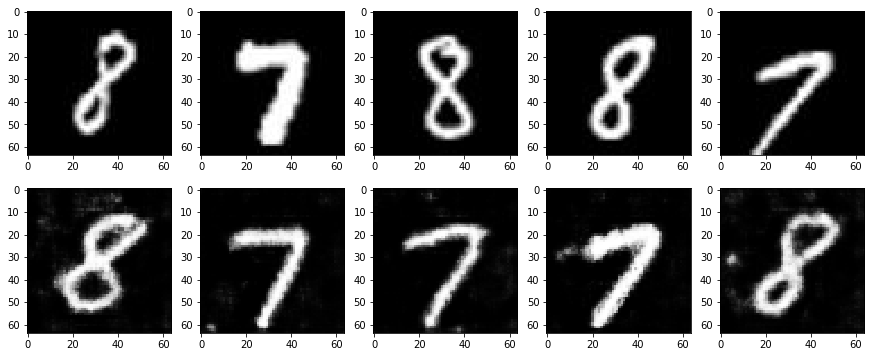

In [97]:
# 生成画像と訓練データを可視化する
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 入力の乱数生成
batch_size = 8
z_dim = 20
fixed_z = torch.randn(batch_size, z_dim)
fixed_z = fixed_z.view(fixed_z.size(0), fixed_z.size(1), 1, 1)

# 画像生成
fake_images, am1, am2 = G_update(fixed_z.to(device))

# 訓練データ
batch_iterator = iter(train_dataloader)  # イタレータに変換
imges = next(batch_iterator)  # 1番目の要素を取り出す


# 出力
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    # 上段に訓練データを
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')

    # 下段に生成データを表示する
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')


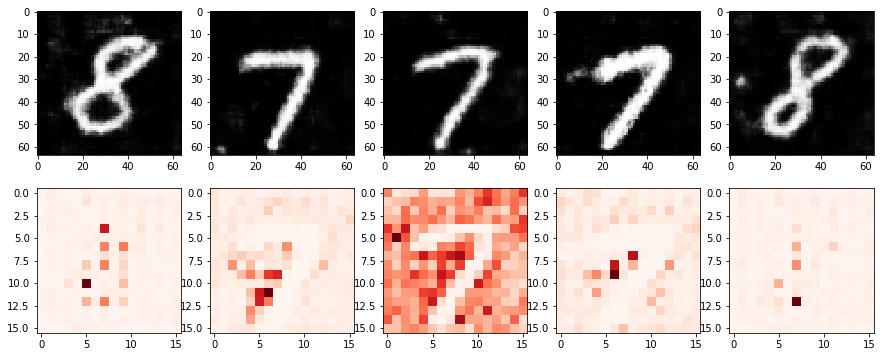

In [111]:
# Attentiom Mapを出力
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):

    # 上段に生成した画像データを
    plt.subplot(2, 5, i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')

    # 下段にAttentin Map1の画像中央のピクセルのデータを
    plt.subplot(2, 5, 5+i+1)
    am = am1[i].view(16, 16, 16, 16)
    am = am[7][7]  # 中央に着目
    plt.imshow(am.cpu().detach().numpy(), 'Reds')


以上